In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
import pandas as pd
# file_path = '/content/drive/MyDrive/NLP_assignment_4/'
file_path = ''

In [2]:
!pip install tensorflow

   ---------------------------------------- 0.0/422.5 kB ? eta -:--:--
   --------------------------------------  419.8/422.5 kB 13.2 MB/s eta 0:00:01
   ---------------------------------------- 422.5/422.5 kB 5.3 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 4.25.0
    Uninstalling protobuf-4.25.0:
      Successfully uninstalled protobuf-4.25.0


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
mysql-connector-python 8.0.32 requires protobuf<=3.20.3,>=3.11.0, but you have protobuf 4.23.4 which is incompatible.


In [4]:
import json
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

def load_and_preprocess_data(file_path):

    tokenizer = Tokenizer()
    combined_texts = []
    combined_emotion_changes = []

    with open(file_path, 'r') as file:
        data = json.loads(file.read())

        texts = [utterance for episode in data for utterance in episode["utterances"]]
        emotion_changes = [trigger for episode in data for trigger in episode["triggers"]]

        tokenizer.fit_on_texts(texts)

        combined_texts += texts
        combined_emotion_changes += emotion_changes

    sequences = tokenizer.texts_to_sequences(combined_texts)
    max_sequence_len = max(len(seq) for seq in sequences)
    padded_sequences = pad_sequences(sequences, maxlen=max_sequence_len, padding='post')
    emotion_changes_array = np.array(combined_emotion_changes)

    return padded_sequences, emotion_changes_array, tokenizer

X, y, tokenizer = load_and_preprocess_data(file_path)
X.shape, y.shape

((58957, 69), (58957,))

In [29]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GRU, Dense
from tensorflow.keras.utils import to_categorical
import tensorflow as tf

X_train, y_train, tokenizer, max_len = load_and_preprocess_data('train_file.json')
X_test, y_test, _, _ = load_and_preprocess_data('val_file.json')

X_train = np.asarray(X_train).astype('float32')
X_test = np.asarray(X_test).astype('float32')
y_train = np.asarray(y_train).astype('float32')
y_test = np.asarray(y_test).astype('float32')


X_train = np.nan_to_num(X_train)
X_test = np.nan_to_num(X_test)
y_train = np.nan_to_num(y_train)
y_test = np.nan_to_num(y_test)

X_train_tensor = tf.convert_to_tensor(X_train)
X_test_tensor = tf.convert_to_tensor(X_test)
y_train_tensor = tf.convert_to_tensor(y_train)
y_test_tensor = tf.convert_to_tensor(y_test)


vocab_size = len(tokenizer.word_index) + 1  

model = Sequential()
model.add(Embedding(vocab_size, 100, input_length=X_train.shape[1]))
model.add(GRU(64, return_sequences=True))
model.add(GRU(32))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test), batch_size=32)

y_pred = model.predict(X_test) > 0.5


from sklearn.metrics import f1_score
f1 = f1_score(y_test, y_pred, average='macro')
print('F1 Score:', f1)

model.save('model2_task2.h5')

Epoch 1/10
1843/1843 [==============================] - 125s 81ms/step - loss: 0.4408 - accuracy: 0.8413 - val_loss: 0.4357 - val_accuracy: 0.8425
Epoch 2/10
1843/1843 [==============================] - 97s 66ms/step - loss: 0.4386 - accuracy: 0.8413 - val_loss: 0.4355 - val_accuracy: 0.8425
Epoch 3/10
1843/1843 [==============================] - 100s 68ms/step - loss: 0.4384 - accuracy: 0.8413 - val_loss: 0.4357 - val_accuracy: 0.8425
Epoch 4/10
1843/1843 [==============================] - 101s 68ms/step - loss: 0.4383 - accuracy: 0.8413 - val_loss: 0.4376 - val_accuracy: 0.8425
Epoch 5/10
1843/1843 [==============================] - 96s 65ms/step - loss: 0.4361 - accuracy: 0.8413 - val_loss: 0.4298 - val_accuracy: 0.8425
Epoch 6/10
1843/1843 [==============================] - 98s 66ms/step - loss: 0.4170 - accuracy: 0.8413 - val_loss: 0.4148 - val_accuracy: 0.8425
Epoch 7/10
1843/1843 [==============================] - 110s 75ms/step - loss: 0.3898 - accuracy: 0.8432 - val_loss: 0.40

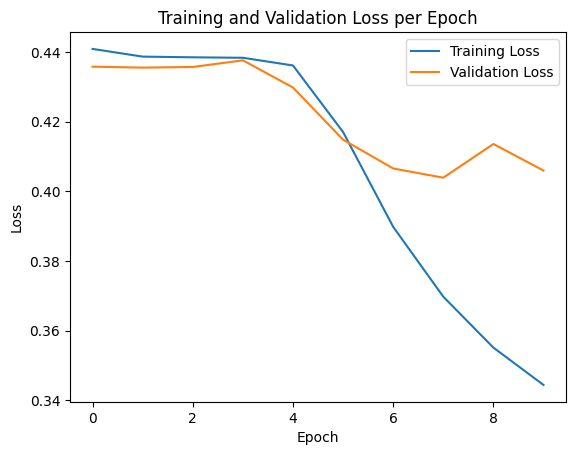

In [22]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Demo

In [33]:
from sklearn.metrics import f1_score
import numpy as np
from tensorflow.keras.models import load_model

loaded_model = load_model('model2_task2.h5')
test_path = ''

with open(test_path, 'r') as file:
    new_test_data = json.load(file)

new_X = tokenizer.texts_to_sequences([utterance for episode in new_test_data for utterance in episode["utterances"]])
new_X = pad_sequences(new_X, maxlen=X_train.shape[1], padding='post')
new_y = np.array([trigger for episode in new_test_data for trigger in episode["triggers"]])

new_y = np.asarray(new_y).astype('float32')

new_y_pred = (model.predict(new_X) > 0.5).astype(int)

if np.isnan(new_y).any():
    nan_indices = np.where(np.isnan(new_y))[0]
    clean_new_y = np.delete(new_y, nan_indices)

    clean_new_y_pred = np.delete(new_y_pred, nan_indices)
else:
    clean_new_y = new_y
    clean_new_y_pred = new_y_pred

new_f1 = f1_score(clean_new_y, clean_new_y_pred, average='macro')
print('F1 Score on new test data:', new_f1)